Notebook for calculating conditional mutual information between features (including engineered ones) and salePrice

**Imports**

In [1]:

import json
import os
import pathlib

#
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.pipeline

#
import knncmi
import pyplotterlib.standard.plotters as ppl


#
import project_path
import cond_mi as condMIHelp
import preproc_pipes as preProcPipeHelp
import model_wrappers as modelWrapHelp
import train_pipes as trainPipeHelp


**Configuration Variables**

In [2]:
#Needs to be True for first run; subsequent runs can then avoid doing the expensive calculations
RERUN_RANKING = False

#
SAVE_FOLDER = os.path.join( os.getcwd(), "conditional_mutual_info_recursive" )
pathlib.Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)

#
TRAIN_PATH = os.path.abspath( os.path.join("..","..","raw_data","train.csv")  )

#
_currKwargs = {"constrainedLayout":True, "figHeightPerRow":2.5, "figWidthPerCol":4, "nColsGrid":4}
RECT_PLOTTER = ppl.RectMultiPlotter(**_currKwargs)


**Import the data**

In [3]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)

**Process the data (including adding engineered features)**

Build the main pipeline

In [4]:
#Remove anything from the training set i know to be an outlier [from results in other notebooks]
_outlierIDs = [524, 945, 1299]

#Features we add before any factorisation/cleaning
_preFactorFeats = ["FenceQual", "NumbStoreys_fromHouseStyle"]



#Features we can add after factorisation/cleaning (in other notebooks they'll be added at training time)
_extraFeats = ["BsmtFractUnfurnished", "GarageAreaTimesFinish", "NumbBsmtBath", "NumbBath",
               "OverallQualTimesCond", "PoolQualTimesCond", "PorchLikeArea", "Spaciousness",
               "TotalSFLiv", "TotalSFLivOverLotArea", "YearSold_Fract"]


#
_ordEncoder = preProcPipeHelp.OrdinalEncoder( preProcPipeHelp.getStandardOrdinalEncodeKeys() )

#Adding target-encoded versions of some features
_featsToEncode = ["Neighborhood", "Exterior1st", "Condition1", "HouseStyle", "GarageType",
                  "Foundation", "LotConfig", "SaleType", "RoofMatl", "MSZoning", "SaleCondition",
                  "RoofStyle"]
_nFolds, _mVal = 3,10
_targEncodeAll = preProcPipeHelp.TargEncoderMEst_Kfold(_nFolds,_featsToEncode, mVal=_mVal)



#Create the pipeline
_pipeVars = [ ("Add some pre-factorisation features", preProcPipeHelp.EngFeatureAdder(_preFactorFeats) ),
              ("Remove outliers", preProcPipeHelp.RemoveOutliersById(_outlierIDs) ),
               ("Replace text values with basic ordinal encoding", _ordEncoder),
               ("Factorise any remaining categorical groups", preProcPipeHelp.FactorizeRemainingCateGroups() ),
               ("Impute NaN values for numerical fields", trainPipeHelp.TransformNumericalNaN()),
              ("Add remaining engineered features", preProcPipeHelp.EngFeatureAdder(_extraFeats) ),
              ("Add target encoded versions of some features", _targEncodeAll )
            ]

procPipeline = sk.pipeline.Pipeline(_pipeVars)


Apply the pipeline; add the scaling separately

In [5]:
PROC_TRAIN = procPipeline.fit_transform(RAW_TRAIN)
_scaler = trainPipeHelp.StandardScaler().fit(PROC_TRAIN)
SCALED_PROC_TRAIN = _scaler.transform(PROC_TRAIN)

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/preproc_pipes.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.trainFitArray[outName].iloc[valIndices] = newVals
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/preproc_pipes.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [6]:
PROC_TRAIN.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Condition1_m10,HouseStyle_m10,GarageType_m10,Foundation_m10,LotConfig_m10,SaleType_m10,RoofMatl_m10,MSZoning_m10,SaleCondition_m10,RoofStyle_m10
0,1,60,0,65.0,8450,0,0,4,0,0,...,182772.147921,207523.047158,201123.156422,224378.443323,174519.011386,172233.652257,178924.339492,189204.086992,173960.441643,168858.404328
1,2,20,0,80.0,9600,0,0,4,0,0,...,149222.786796,174960.165221,201123.156422,148566.317065,180804.816404,172233.652257,178924.339492,189204.086992,173960.441643,168858.404328


In [7]:
SCALED_PROC_TRAIN.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Condition1_m10,HouseStyle_m10,GarageType_m10,Foundation_m10,LotConfig_m10,SaleType_m10,RoofMatl_m10,MSZoning_m10,SaleCondition_m10,RoofStyle_m10
0,-1.729522,0.072821,-0.42708,-0.221274,-0.203603,-0.064305,-0.24329,0.701409,-0.30267,0.0,...,0.133642,1.249714,0.536217,1.112516,-0.591908,-0.323455,-0.321777,0.322284,-0.26723,-0.647855
1,-1.727150,-0.872394,-0.42708,0.491570,-0.086954,-0.064305,-0.24329,0.701409,-0.30267,0.0,...,-2.913875,-0.337956,0.536217,-0.868888,0.015167,-0.323455,-0.321777,0.322284,-0.26723,-0.647855


In [8]:
PROC_TRAIN["SaleCondition"].unique()

array([0, 1, 2, 3, 4, 5])

In [9]:
#>6 unique values due to k-fold target encoding
PROC_TRAIN["SaleCondition_m10"].unique()

array([173960.44164271, 152767.87861187, 263428.94706685, 176102.48081363,
       180560.23827499, 159046.97037291, 175274.34433532, 258120.31086758,
       157465.537186  , 172601.76805937, 170369.422225  , 161432.86838076,
       176595.37520417, 269564.53425989, 142945.52385267, 160317.80370625,
       171711.36444749])

In [10]:
SCALED_PROC_TRAIN.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'Condition1_m10', 'HouseStyle_m10', 'GarageType_m10', 'Foundation_m10',
       'LotConfig_m10', 'SaleType_m10', 'RoofMatl_m10', 'MSZoning_m10',
       'SaleCondition_m10', 'RoofStyle_m10'],
      dtype='object', length=106)

**Look at the first 30 most important features**

In [11]:
%%prun
#          312749901 function calls (312720126 primitive calls) in 1407.315 seconds
#    Ordered by: internal time

#    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
#      2355  589.987    0.251  617.611    0.262 knncmi.py:13(getPairwiseDistArray)savePath = os.path.join(SAVE_FOLDER, "feats_cond_mi_n30.json")

savePath = os.path.join(SAVE_FOLDER, "feats_cond_mi_n30.json")
if RERUN_RANKING:
    featsAndExtraMI = condMIHelp.recursivelyAddFeatsWithHighestCMI(SCALED_PROC_TRAIN, "SalePrice", stopAfterN=30)
    with open(savePath,"wt") as f:
        json.dump(featsAndExtraMI, f)
else:
    with open(savePath,"rt") as f:
        featsAndExtraMI = json.load(f)

**Create a split-axis bar chart showing CMI after recursively adding**

In [12]:
_groupLabels = list( reversed([x[0] for x in featsAndExtraMI]) )
_dataVals = list( reversed([ x[1] for x in featsAndExtraMI ]) )

In [13]:
_currKwargs = {"figSizeOnCreation":[5,8],
               "groupLabels":_groupLabels, "groupLabelRotation":0,
               "plotData1D":[_dataVals], "plotHorizontally":True,
               "xLabelStr": "Conditional Mutual Information"}
templBarPlotter = ppl.BarPlotter(**_currKwargs)

In [14]:
_currKwargs = {"axisSizeLinear":False, "plotter":templBarPlotter, "xLimits":[[0.0,0.25],[0.35,0.8]]}
splitPlotter = ppl.SplitAxisPlotterCreator(**_currKwargs)

{'plotter': <pyplotterlib.standard.private.split_axis_plotter.SplitAxisPlotter at 0x7f508b2bed10>}

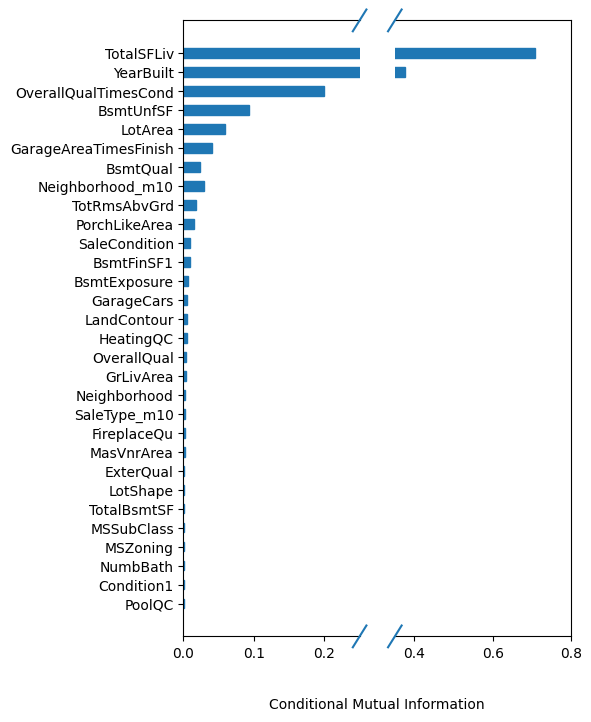

In [15]:
splitPlotter.createPlot()

In [16]:
featsAndExtraMI

[['TotalSFLiv', 0.7085967405172178],
 ['YearBuilt', 0.3747739219880326],
 ['OverallQualTimesCond', 0.19959986485820885],
 ['BsmtUnfSF', 0.0926704473490229],
 ['LotArea', 0.05947102773183818],
 ['GarageAreaTimesFinish', 0.04077049504567126],
 ['BsmtQual', 0.02401682978969014],
 ['Neighborhood_m10', 0.02930803833085061],
 ['TotRmsAbvGrd', 0.0172468793608686],
 ['PorchLikeArea', 0.015037564502590523],
 ['SaleCondition', 0.009518564688856968],
 ['BsmtFinSF1', 0.009945257626929781],
 ['BsmtExposure', 0.006486029723624519],
 ['GarageCars', 0.005702138196484528],
 ['LandContour', 0.005127308268857598],
 ['HeatingQC', 0.0046842820438983334],
 ['OverallQual', 0.002919548248367395],
 ['GrLivArea', 0.003127963489505591],
 ['Neighborhood', 0.002377637138621542],
 ['SaleType_m10', 0.0018205373068632413],
 ['FireplaceQu', 0.001901872277461875],
 ['MasVnrArea', 0.0018070891739257026],
 ['ExterQual', 0.0011357302016233772],
 ['LotShape', 0.0010855397071788191],
 ['TotalBsmtSF', 0.0009731772664629884],

**Prepare data for fitting with cross-val**

In [17]:
#Applied to all data once before fitting
_preProcComps = [ ("Add some pre-factorisation features", preProcPipeHelp.EngFeatureAdder(_preFactorFeats) ),
                  ("Remove outliers", preProcPipeHelp.RemoveOutliersById(_outlierIDs) ),
                 ("Replace text values with basic ordinal encoding", _ordEncoder),
                 ("Factorise any remaining categorical groups", preProcPipeHelp.FactorizeRemainingCateGroups() ), ]

preProcPipe = sk.pipeline.Pipeline(_preProcComps)


_featsToEncode = ["Neighborhood", "Exterior1st", "Condition1", "HouseStyle", "GarageType",
                  "Foundation", "LotConfig", "SaleType", "RoofMatl", "MSZoning", "SaleCondition",
                  "RoofStyle"]
_targEncodeTrain = trainPipeHelp.MEncodeMultiple(_featsToEncode, mVal=10)

#Applied at training time to only the training fold
_trainPipeComps = [ ("Impute NaN values for numerical fields", trainPipeHelp.TransformNumericalNaN()),
                    ("Add remaining engineered features", preProcPipeHelp.EngFeatureAdder(_extraFeats) ),
                    ("Add target encoded features", _targEncodeTrain )
                  ]
TRAIN_PIPE = sk.pipeline.Pipeline(_trainPipeComps)


In [18]:
INP_DATA = preProcPipe.fit_transform(RAW_TRAIN)

**Get multiple shuffles of the data**

In [19]:
def _getShuffledFrame(inpFrame, randomSeed=0):
    outFrame = inpFrame.sample(frac=1.0, random_state=randomSeed)
    outFrame = outFrame.sample(frac=1.0, axis=1, random_state=randomSeed)
    return outFrame

In [20]:
randomSeeds = [64, 89, 17]
SHUFFLED_FRAMES = [_getShuffledFrame(INP_DATA, randomSeed=x) for x in randomSeeds]

**Look at model scores after recursively adding features**

In [21]:
sk.model_selection.cross_val_score?

In [22]:
modelWrapHelp.RandomForestWrapper?

In [23]:
def scoreModelAfterAddingEachFeat(inpFrame, inpFeats, randomSeed=0):
    outVals = list()
    for idx, unused in enumerate(inpFeats,start=1):
        currFeats = inpFeats[:idx]
#         print("currFeats = {}".format(currFeats))
        currModel = modelWrapHelp.RandomForestWrapper(currFeats, trainPipe=TRAIN_PIPE, logTarget=False)
#         print("currModel.feats = {}".format(currModel.feats))
        currScore = np.mean( sk.model_selection.cross_val_score(currModel, inpFrame) )
        outVals.append(currScore)
    return outVals

In [24]:
%%prun
inpFeats = [x[0] for x in featsAndExtraMI ]

outVals = list()
for shuffledFrame, randomSeed in zip(SHUFFLED_FRAMES,randomSeeds):
    currVals = scoreModelAfterAddingEachFeat(shuffledFrame, inpFeats, randomSeed=randomSeed)
    outVals.append(currVals)



/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]
/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on

/home/richard/Work/random/learning_ml/kaggle_comps/house_prices_github/shared_code/train_pipes.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpFrame[inpField].loc[ nanFrame.index ] = inpFrame[replField].loc[ nanFrame.index ]


In [25]:
_plotDataA = [ [idx,val] for idx,val in enumerate(outVals[0],start=1) ]
_plotDataB = [ [idx,val] for idx,val in enumerate(outVals[1],start=1) ]
_plotDataC = [ [idx,val] for idx,val in enumerate(outVals[2],start=1) ]
plotData = [ _plotDataA, _plotDataB, _plotDataC ]


In [31]:
_currKwargs = {"dataLabels":["A","B","C"], "gridLinesShowY":True, "lineMarkerStyles":["x"],
               "plotData": plotData, "showLegend":True, "xLabelStr":"Number of Features", "yLabelStr":"Loss"}
templPlotter = ppl.LinePlotter(**_currKwargs)

zoomOutPlotter = templPlotter.createFactory(xLimit=[0,7], yLimit=[0.12,0.27])
zoomInPlotter = templPlotter.createFactory(xLimit=[7,30], yLimit=[0.12,0.16])

{}

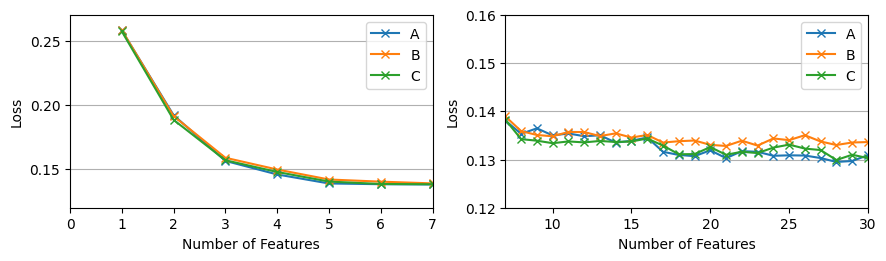

In [32]:
RECT_PLOTTER.createPlot(plotters=[zoomOutPlotter, zoomInPlotter])

In [28]:
plotData

[[[1, 0.25787187947754625],
  [2, 0.19195362799886231],
  [3, 0.1563997274874481],
  [4, 0.1458741032320175],
  [5, 0.13885932517520727],
  [6, 0.1382884321695697],
  [7, 0.13807177956913713],
  [8, 0.1353231565298917],
  [9, 0.1364647453753209],
  [10, 0.13498545290200983],
  [11, 0.13539760382120317],
  [12, 0.13482634275189356],
  [13, 0.1350237958140929],
  [14, 0.13351033136243504],
  [15, 0.13387541322083069],
  [16, 0.13457172759550637],
  [17, 0.131598417353226],
  [18, 0.13094489382088692],
  [19, 0.13069059467927532],
  [20, 0.13190918146562142],
  [21, 0.1302759613343794],
  [22, 0.1317298211213808],
  [23, 0.13159943478477948],
  [24, 0.13076977429853162],
  [25, 0.1308667994937322],
  [26, 0.13082361607499496],
  [27, 0.13030146264645723],
  [28, 0.12949236786378243],
  [29, 0.12968605719442622],
  [30, 0.1308892241986455]],
 [[1, 0.25808679766619036],
  [2, 0.19123511219980616],
  [3, 0.15885323212644525],
  [4, 0.14971072792178397],
  [5, 0.1419458650617992],
  [6, 0.140